In [1]:
from numpy import *
from numpy import linalg as la
from scipy import linalg as sa

import matplotlib.pyplot as plt

In [10]:
from tensorflow.keras.models import load_model

In [2]:
def mubpom():
    p1 = array([1,0])
    p2 = array([0,1])
    mub = zeros([6,1,2])+1j*zeros([6,1,2])
    mub[0] = p1
    mub[1] = p2
    mub[2] = 1/sqrt(2)*(p1+p2)
    mub[3] = 1/sqrt(2)*(p1-p2)
    mub[4] = 1/sqrt(2)*(p1+1j*p2)
    mub[5] = 1/sqrt(2)*(p1-1j*p2)
    mubp = [transpose(mub[i])@conjugate(mub[i]) for i in range(6)]
    return mubp

def pauliK(data1,exc):
    """function pauliK takes full probability vector data1 and number of excluded projections exc and returns"""
    """probability vector data and projections with zeros in the appropriate places"""
    data = data1/sum(data1)
    mub = mubpom()
    mubP = array([kron(mub[i],mub[j])/9 for i in range(6) for j in range(6) ])
    myList=list(range(36))
    random.shuffle(myList)
    for i in myList[0:exc]:
        mubP[i] = zeros([4,4],complex)
        data[i] = 0
    return data,mubP

def concM(rrho):
    """Return the concurrence of a density matrix."""
    sigma2y = array([[0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0]])
    rho_spinflipped = sigma2y @ rrho.conj() @ sigma2y
    R = sa.sqrtm(sa.sqrtm(rrho) @ rho_spinflipped @ sa.sqrtm(rrho))
    R_eigen = la.eig(R)[0]
    R_eigen = sort(R_eigen)[::-1]
    concurrence = max([0, R_eigen[0] - sum(R_eigen[1:])])
    # check_imag(concurrence)
    return abs(concurrence)

def MLalg(data, rhoinit,povm,epsilon,stop):
    """Regularized maximum likelihood iterative algorithm"""
    rho = rhoinit
    trdist = 1
    k = 0
    pomS = zeros([4,4], complex)
    for n in range(shape(povm)[0]): pomS = pomS + povm[n]
#     Gop = sa.fractional_matrix_power(pomS,-1/2)
    Gop = sa.pinv(sa.fractional_matrix_power(pomS,1/2))
    while trdist > epsilon and k<stop:
        R = zeros([4,4], complex)
        prob = probdists(rho,povm)
        for i in range(shape(povm)[0]):
            if data[i]>10**(-10):
                R += data[i]/prob[i]*povm[i]
        rhonew = dot(dot(Gop,dot(R,rho)),dot(R,Gop))
        rhonew = rhonew/trace(rhonew)
        trdist = trace(dot((rho-rhonew),(rho-rhonew)))
        rho = rhonew
        k+=1
    return rho

In [8]:
"""data gathered from the quantum dot source"""

dataQuantDot = loadtxt('experiment/tomo_small.dat')

#normalization

dataQDot = dataQuantDot[:,1]/sum(dataQuantDot[:,1])

#normalization with respect to singles

gm = sqrt(multiply(dataQuantDot[:,2],dataQuantDot[:,3]))
dataRenormSingles = divide(dataQDot,gm)
dataRenormSingles = dataRenormSingles/sum(dataRenormSingles)

In [7]:
mub = mubpom()
mub2 = array([kron(mub[i],mub[j])/9 for i in range(6) for j in range(6)])

In [9]:
# cQdot = zeros([100])
# for k in range(100):
#     dataQuantDot = loadtxt('experiment/tomo_small.dat')
#     dataQDot = dataQuantDot[:,1]
#     dataQDot = random.poisson(dataQDot)
#     gm = sqrt(multiply(dataQuantDot[:,2],dataQuantDot[:,3]))
#     dataRenormSingles = divide(dataQDot,gm)
#     dataRenormSingles = dataRenormSingles/sum(dataRenormSingles)
#     cQdot[k] = concM(MLalg(dataRenormSingles, identity(4)/4,mub2,10**(-14),100000))

In [10]:
random.poisson(dataQDot)

array([7696,  238, 4118, 3401, 5260, 2397,  405, 1142, 1597,  429, 1084,
        600, 2608, 1114, 3055, 1209, 2757, 1059, 3169,  488, 1746, 1666,
       2452, 1329, 5195, 1474, 4705, 2202, 3702, 2604, 1984,  910, 1765,
       1239, 2480,  711])

In [4]:
"""regularized maximum likelihood method"""

# concMlR = zeros([33,100])
# concMlmean = zeros(33)
# concMlstd = zeros(33)
# for m in range(33):
#     print(m)
#     for n in range(100):
#         data,mub2 = pauliK(dataRenormSingles,m)
#         concMlR[m,n] = concM(MLalg(data, identity(4)/4,mub2,10**(-14),100000))
#    concMlmean[m] = mean(concMlR[m,:])
#    concMlstd[m] = std(concMlR[m,:])
# savetxt("qdots_new_data/Ml_tomo_small.txt", concMlR, fmt="%s")

'regularized maximum likelihood method'

In [ ]:
"""specific DNN's estimates"""

# pick a specific tuple from all possible pauli projections, nR = 0,1,2,3,4
nR = 0

def nMubs(nProj):
    mubsN = linspace(0,35,nProj,dtype=int)
    mub = mubpom()
    mub2 = array([kron(mub[i],mub[j])/9 for i in range(6) for j in range(6)])
    mub3 = array([ mub2[n] for n in mubsN ])
    return mub3

def whichProj(nR,k):
    file1 = load("spec_pauli_projections/PauliR"+str(nR)+str(k)+".npz")
    mub3 = file1['mub3']
    l = array([ array([trace(mub3[j]@mub2[i]) for i in range(36)]) for j in range(k) ])
    l[l>0.01]=1
    l[l<1]=0
    l = sum(l,axis=0)
    l = real(l)
    return l

def selectedData(data,nProj):
#     mubsN = linspace(0,35,nProj,dtype=int)
    l = whichProj(nR,nProj)
#     dataS = array([ data[n] for n in mubsN ])
    dataS = data[l>0]
    return dataS

dictBestModel={}
for k in pom:
    dictBestModel[str(k)]="DNNs/bestModelPauliConcProjR"+str(nR)+"v7"+str(2*k)
    
concSpecR0 = zeros(pomS)
concML = zeros(pomS)
for kk in pom:
    nProj = 2*kk
    """One can get estimates of concurrence from specific DNN's for different data by changing the input to"""
    """selectedData(,)"""
    data = selectedData(dataRenormSingles,nProj)
    data = data/sum(data)
    model = load_model(dictBestModel[str(kk)]+'.h5',compile=False)
    concSpecR0[kk-1]=model.predict(reshape(data,(1,nProj)))[0]

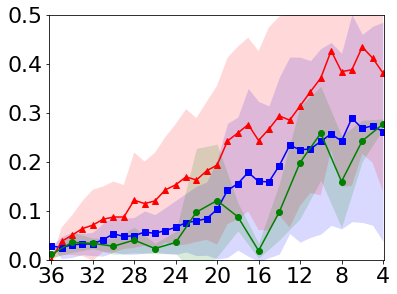

In [138]:
"""final figure for the quantum dot source"""

aP = loadtxt('experiment/data_QDot_Spec_DNNs.txt')
xx = linspace(0,32,33,dtype=int)
xx2 = linspace(0,32,17,dtype=int)
QDotNetEval = loadtxt('experiment/net_tomo_small_Rsingles.txt')[:,0:33]
QDotMlEval = loadtxt('experiment/Ml_tomo_small_Rsingles.txt')[0:33,:]

AM=mean(abs(QDotNetEval-QDotMlEval[0,0]),axis=0)
AP=std(abs(QDotNetEval-QDotMlEval[0,0]),axis=0)
AMlM=mean(abs(QDotMlEval-QDotMlEval[0,0]),axis=1)
AMlP=std(abs(QDotMlEval-QDotMlEval[0,0]),axis=1)

AQDM = mean(abs(a1-QDotMlEval[0,0]),axis=0)[0:17][::-1]
AQDS = std(abs(a1-QDotMlEval[0,0]),axis=0)[0:17][::-1]

plt.figure(figsize=(6, 4.5))

plt.plot(xx,AM,'s-',color = 'blue',label='Devide indep.')
plt.fill_between(xx,AM+AP,AM-AP,alpha=0.15,color ='blue',linewidth=0.0)
plt.plot(xx,AMlM,'^-',color = 'red',label='RML')
plt.fill_between(xx,AMlM+AMlP,AMlM-AMlP,alpha=0.15,color ='red',linewidth=0.0)
plt.xticks(linspace(0,32,9,dtype=int),linspace(4,36,9,dtype=int)[::-1])

plt.plot(xx2,AQDM,'o-',color = 'green',label='Specific projs.')
plt.fill_between(xx2,AQDM+AQDS,AQDM-AQDS,alpha=0.15,color ='green',linewidth=0.0)


plt.xticks(linspace(0,32,9,dtype=int),linspace(4,36,9,dtype=int)[::-1])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5])
plt.tick_params(labelsize=22)
plt.xlim([-0.2,32.1])
plt.ylim([0,0.5])


plt.savefig('mae_small_ren_singles.svg')
plt.show()

In [61]:
mean(abs(aP-QDotMlEval[0,0]),axis=0)[0:17][::-1]

array([0.01165407, 0.02910616, 0.0361344 , 0.03114361, 0.03181016,
       0.0245402 , 0.04143178, 0.03288534, 0.14523806, 0.08184354,
       0.02316216, 0.116315  , 0.22839088, 0.2721656 , 0.16947955,
       0.23915624, 0.27764867])

In [114]:
percentile(abs(qqq-PSMlEval[0,0]),17,axis=0)[0:17][::-1]

array([0.00247065, 0.00862062, 0.00419109, 0.00677771, 0.00371877,
       0.0065923 , 0.01268144, 0.01042017, 0.00826195, 0.01041415,
       0.00187655, 0.03141361, 0.02078048, 0.03832159, 0.2396286 ,
       0.25450857, 0.51140625])

(0.0, 0.5)

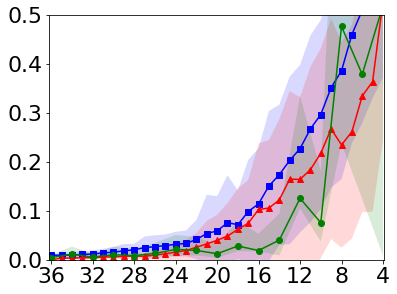

In [126]:
"""figure for data measured from the photonic source"""

q1 = loadtxt('experiment/concSpecQOLO1.txt')
q8 = loadtxt('experiment/concSpecQOLO8.txt')

kk = 1
qqq = q1
xx = linspace(0,32,33,dtype=int)
xx2 = linspace(0,32,17,dtype=int)
PSNetEval = loadtxt('experiment/netPredConcQOLO'+str(kk)+'.txt')[:,0:33]
PSMlEval = loadtxt('experiment/MlPredConcQOLO'+str(kk)+'.txt')[0:33,:]
AM=mean(abs(PSNetEval-PSMlEval[0,0]),axis=0)
AP=std(abs(PSNetEval-PSMlEval[0,0]),axis=0)
AMlM=mean(abs(PSMlEval-PSMlEval[0,0]),axis=1)
AMlP=std(abs(PSMlEval-PSMlEval[0,0]),axis=1)
ASM=mean(abs(qqq-PSMlEval[0,0]),axis=0)[0:17][::-1]
ASP=std(abs(qqq-PSMlEval[0,0]),axis=0)[0:17][::-1]

ASP1 = percentile(abs(qqq-PSMlEval[0,0]),17,axis=0)[0:17][::-1]
ASP2 = percentile(abs(qqq-PSMlEval[0,0]),84,axis=0)[0:17][::-1]


plt.subplots(figsize=(6, 4.5))
plt.plot(xx,AM,'s-',color = 'blue',label='Devide indep.')
plt.fill_between(xx,AM+AP,AM-AP,alpha=0.15,color ='blue',linewidth=0.0)

plt.plot(xx,AMlM,'^-',color = 'red',label='RML')
plt.fill_between(xx,AMlM+AMlP,AMlM-AMlP,alpha=0.15,color ='red',linewidth=0.0)

plt.plot(xx2,ASM,'o-',color = 'green',label='Specific projs')
plt.fill_between(xx2,ASM+ASP2,ASM-ASP1,alpha=0.15,color ='green',linewidth=0.0)

plt.xticks(linspace(0,32,9,dtype=int),linspace(4,36,9,dtype=int)[::-1])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5])

plt.tick_params(labelsize=22)
plt.xlim([-0.2,32.1])
plt.ylim([0.0,0.5])

# plt.ylabel('MAE',fontsize=14)
# plt.xlabel('# of Pauli projectors',fontsize=14)

# plt.legend(loc='upper left')

# plt.savefig('concMAEQOLO'+str(kk)+'.svg')

In [117]:
q1[:,1]

array([0.62643677, 0.62643677, 0.36284086, 0.46185359, 0.94986004])

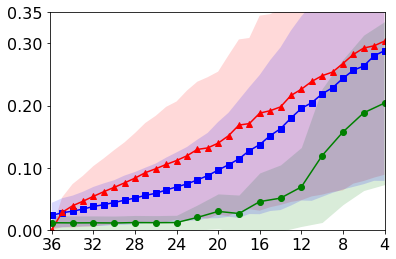

In [3]:
"""Mean average error for concurrence estimation with different approaches"""

xx = linspace(0,32,33,dtype=int)
xx2 = linspace(0,32,17,dtype=int)

netEvalConc = loadtxt('concurrence/netPredConcv9.txt')[:,0:33]
mlEvalConc = loadtxt('concurrence/mlMaeMean.txt')[0:33,:]
netSpecEvalConc = loadtxt('concurrence/concSpecMAER0v7.txt')[:,0:17]


NEM=mean(netEvalConc,axis=0)
NES=std(netEvalConc,axis=0)

NEMlM = mlEvalConc[:,0]
NEMlS = mlEvalConc[:,1]

NSM = netSpecEvalConc[0][::-1]
NSS = netSpecEvalConc[1][::-1]

plt.subplots(figsize=(6, 4))

plt.fill_between(xx,NEMlM+NEMlS,NEMlM-NEMlS,alpha=0.15,color ='red',linewidth=0.0)
plt.fill_between(xx2,NSM+NSS,NSM-NSS,alpha=0.15,color ='green',linewidth=0.0)

plt.plot(xx,NEM,'s-',color = 'blue')
plt.fill_between(xx,NEM+NES,NEM-NES,alpha=0.15,color ='blue',linewidth=0.0)

plt.plot(xx,NEMlM,'^-',color = 'red')
plt.plot(xx2,NSM,'o-',color = 'green')

plt.xticks(linspace(0,32,9,dtype=int),linspace(4,36,9,dtype=int)[::-1])
plt.yticks(array([0,0.1,0.2,0.3,0.35]))
plt.tick_params(labelsize=16)
plt.xlim([-0.2,32])
plt.ylim([0,0.35])
plt.savefig('conc2qMAEHaar.png')

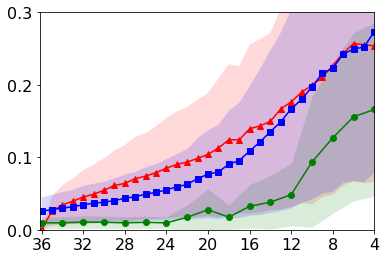

In [4]:
"""Mean average error for mutual information estimation with different approaches"""

xx = linspace(0,32,33,dtype=int)
xx2 = linspace(0,32,17,dtype=int)

netEvalMI = loadtxt('MI_2q/netPredMutInfv9.txt')[:,0:33]
mlEvalMI = loadtxt('MI_2q/mlMaeMIMean.txt')[0:33,:]
netSpecEvalMI = loadtxt('MI_2q/MISpecMAER0v7.txt')[:,0:17]

NEM=mean(netEvalMI,axis=0)
NES=std(netEvalMI,axis=0)


NEMlM = mlEvalMI[:,0]
NEMlS = mlEvalMI[:,1]

NSM = netSpecEvalMI[0][::-1]
NSS = netSpecEvalMI[1][::-1]

plt.subplots(figsize=(6, 4))

plt.fill_between(xx,NEMlM+NEMlS,NEMlM-NEMlS,alpha=0.15,color ='red',linewidth=0.0)
plt.fill_between(xx2,NSM+NSS,NSM-NSS,alpha=0.15,color ='green',linewidth=0.0)
plt.fill_between(xx,NEM+NES,NEM-NES,alpha=0.15,color ='blue',linewidth=0.0)

plt.plot(xx,NEMlM,'^-',color = 'red')
plt.plot(xx2,NSM,'o-',color = 'green')
plt.plot(xx,NEM,'s-',color = 'blue')

plt.xticks(linspace(0,32,9,dtype=int),linspace(4,36,9,dtype=int)[::-1])
plt.yticks(array([0,0.1,0.2,0.3]))
plt.tick_params(labelsize=16)
plt.xlim([-0.2,32])
plt.ylim([0,0.3])

plt.savefig('mutInf2qMAEHaar.png')

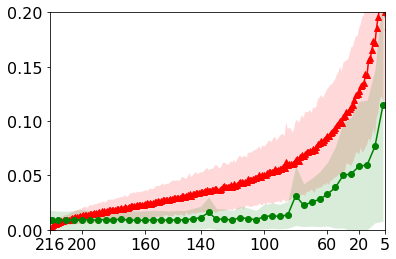

In [5]:
"""Mean average error for mutual information matrix for three qubits estimation with different approaches"""

xx = linspace(0,213,212,dtype=int)
xx2 = append([0],linspace(1,210,43,dtype=int))

mlEvalMI = loadtxt('MI_3q/mInfAMlMean.txt')
mlEvalMIStd = loadtxt('MI_3q/mInfMlStd.txt')
netSpecEvalMI = loadtxt('MI_3q/MI3qMAEv9.txt')[::-1]
netSpecEvalMIStd = loadtxt('MI_3q/MI3qMAEstdv9.txt')[::-1]


NEM=mean(netSpecEvalMI,axis=0)
NES=std(netEvalConc,axis=0)

plt.subplots(figsize=(6, 4))

plt.fill_between(xx,mlEvalMI+mlEvalMIStd,mlEvalMI-mlEvalMIStd,alpha=0.15,color ='red',linewidth=0.0)
plt.fill_between(xx2,netSpecEvalMI+netSpecEvalMIStd,netSpecEvalMI-netSpecEvalMIStd,alpha=0.15,color ='green',linewidth=0.0)

plt.plot(xx,mlEvalMI,'^-',color = 'red')
plt.plot(xx2,netSpecEvalMI,'o-',color = 'green')

# plt.xticks(array([216,200,180,160,140,120,100,80,60,40,20,5])[::-1]-5,[216,200,180,160,140,120,100,80,60,40,20,5])
plt.xticks(array([0,20,60,95,135,175,195,211]),[216,200,160,140,100,60,20,5])
plt.yticks(array([0,0.05,0.1,0.15,0.2,0.25,0.3]))
plt.tick_params(labelsize=16)
plt.xlim([-0.2,211])
plt.ylim([0,0.2])
plt.savefig('mutInf3qMAEHaar.png')

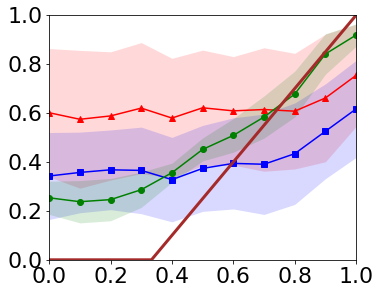

In [9]:
"""concurrence of the Werner state"""

xx = linspace(1,11,11,dtype=int)
x = linspace(0,1,100)
# concTrue = array([max(0,(3*n-1)/2) for n in x])

netSpecConc0 = loadtxt('WsState/concWsR0v7.txt')
netSpecConc1 = loadtxt('WsState/concWsR1v7.txt')
netSpecConc2 = loadtxt('WsState/concWsR2v7.txt')
netSpecConc3 = loadtxt('WsState/concWsR3v7.txt')
netSpecConc4 = loadtxt('WsState/concWsR4v7.txt')


netSC = dstack((netSpecConc0,netSpecConc1,netSpecConc2,netSpecConc3,netSpecConc4))
netSCMean = mean(netSC,axis=2)
netSCStd = std(netSC,axis=2)

netEvalConcM = loadtxt('WsState/netPredWsMv9.txt')
netEvalConcS = loadtxt('WsState/netPredWsSv9.txt')
conMLwSM = loadtxt('WsState/mlPredWsMean.txt')
conMLwSS = loadtxt('WsState/mlPredWsStd.txt')


"""k = 0,1,2,3 corresponds with 36,28,18,8 measurement settings used to estimate concurrence of the Werner state"""

kk = 3

concTrue = array([max(0,(3*n-1)/2) for n in x])

plt.figure(figsize=(5.5, 4.5))

plt.fill_between(xx,conMLwSM[:,kk]+conMLwSS[:,kk],conMLwSM[:,kk]-conMLwSS[:,kk],alpha=0.15,color ='red',linewidth=0.0)
plt.fill_between(xx,netEvalConcM[:,kk]+netEvalConcS[:,kk],netEvalConcM[:,kk]-netEvalConcS[:,kk],alpha=0.15,color ='blue',linewidth=0.0)
plt.fill_between(xx,netSCMean[:,3-kk]+netSCStd[:,3-kk],netSCMean[:,3-kk]-netSCStd[:,3-kk],alpha=0.15,color ='green',linewidth=0.0)

plt.plot(xx,conMLwSM[:,kk],'^-',color = 'red',label='RML')
plt.plot(xx,netEvalConcM[:,kk],'s-',color = 'blue',label='Device indep.')
plt.plot(xx,netSCMean[:,3-kk],'o-',color = 'green',label='Specific projs')
plt.plot(x*10+1,concTrue,'-',color = 'brown',linewidth="3.0",label='true val.')


# plt.xlabel(r'p',fontsize=12)
plt.xticks(array([ 1, 3, 5, 7, 9, 11]),array([0.0, 0.2, 0.4, 0.6, 0.8, 1. ]))


plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlim([1,11])
plt.ylim([0,1])

# plt.show()

plt.savefig('concWerner'+str(kk)+'.png')

In [4]:
nProjAll = 19
pom = array(range(1,nProjAll))

In [71]:
"""specific DNN's estimates"""

# pick a specific tuple from all possible pauli projections, nR = 0,1,2,3,4
nR = 0

def nMubs(nProj):
    mubsN = linspace(0,35,nProj,dtype=int)
    mub = mubpom()
    mub2 = array([kron(mub[i],mub[j])/9 for i in range(6) for j in range(6)])
    mub3 = array([ mub2[n] for n in mubsN ])
    return mub3

def whichProj(nR,k):
    file1 = load("spec_pauli_projections/PauliR"+str(nR)+str(k)+".npz")
    mub3 = file1['mub3']
    l = array([ array([trace(mub3[j]@mub2[i]) for i in range(36)]) for j in range(k) ])
    l[l>0.01]=1
    l[l<1]=0
    l = sum(l,axis=0)
    l = real(l)
    return l

def selectedData(data,nProj):
#     mubsN = linspace(0,35,nProj,dtype=int)
    l = whichProj(nR,nProj)
#     dataS = array([ data[n] for n in mubsN ])
    dataS = data[l>0]
    return dataS

dictBestModel={}
for k in pom:
    dictBestModel[str(k)]="DNNs/bestModelPauliConcProjR"+str(nR)+"v7"+str(2*k)
    
cS = []
for kk in pom:
    nProj = 2*kk
    """One can get estimates of concurrence from specific DNN's for different data by changing the input to"""
    """selectedData(,)"""
    data = selectedData(q1,nProj)
    data = data/sum(data)
    model = load_model(dictBestModel[str(kk)]+'.h5',compile=False)
    preds = model.predict(reshape(data,(1,nProj)))[0]
    cS = append(cS,preds)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 36

In [18]:
cS0 = cS

In [20]:
sS1 = cS

In [22]:
cS2 = cS

In [24]:
cS3 = cS

In [26]:
cS4 = cS

In [55]:
aP[0:17]

array([[0.46352696, 0.36893034, 0.51112956, 0.31299636, 0.23463324,
        0.26165795, 0.15253097, 0.13570219, 0.1972332 , 0.1608392 ,
        0.14465335, 0.14086923, 0.1649397 , 0.16113153, 0.15553138,
        0.14397186, 0.16767621, 0.1794177 ],
       [0.43410605, 0.42017844, 0.22885317, 0.38895631, 0.45092696,
        0.23184162, 0.1470224 , 0.1046544 , 0.5031147 , 0.18829909,
        0.21729285, 0.14741489, 0.14792231, 0.22622445, 0.13551122,
        0.17702585, 0.15157303, 0.18801749],
       [0.45342293, 0.3825337 , 0.3258296 , 0.51674861, 0.53634417,
        0.358805  , 0.17491943, 0.27448586, 0.33950931, 0.1198988 ,
        0.19339204, 0.20518962, 0.15657023, 0.22142914, 0.22500512,
        0.22642514, 0.16837123, 0.16852981],
       [0.46307188, 0.48851565, 0.31563905, 0.57349432, 0.39519233,
        0.31648859, 0.21535483, 0.2932449 , 0.10713837, 0.22398025,
        0.10030439, 0.17051128, 0.24490628, 0.18981895, 0.14119151,
        0.2087121 , 0.18247017, 0.17709208]])

In [130]:
aP = vstack((cS0,sS1,cS2,cS3,cS4))

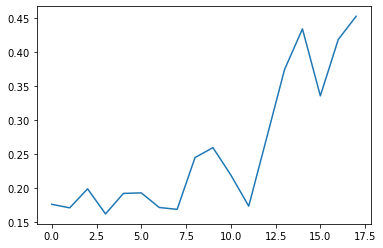

In [135]:
plt.plot(mean(aP.transpose(),axis=1)[::-1])

In [66]:
aP

array([[0.46352696, 0.36893034, 0.51112956, 0.31299636, 0.23463324,
        0.26165795, 0.15253097, 0.13570219, 0.1972332 , 0.1608392 ,
        0.14465335, 0.14086923, 0.1649397 , 0.16113153, 0.15553138,
        0.14397186, 0.16767621, 0.1794177 ],
       [0.43410605, 0.42017844, 0.22885317, 0.38895631, 0.45092696,
        0.23184162, 0.1470224 , 0.1046544 , 0.5031147 , 0.18829909,
        0.21729285, 0.14741489, 0.14792231, 0.22622445, 0.13551122,
        0.17702585, 0.15157303, 0.18801749],
       [0.45342293, 0.3825337 , 0.3258296 , 0.51674861, 0.53634417,
        0.358805  , 0.17491943, 0.27448586, 0.33950931, 0.1198988 ,
        0.19339204, 0.20518962, 0.15657023, 0.22142914, 0.22500512,
        0.22642514, 0.16837123, 0.16852981],
       [0.46307188, 0.48851565, 0.31563905, 0.57349432, 0.39519233,
        0.31648859, 0.21535483, 0.2932449 , 0.10713837, 0.22398025,
        0.10030439, 0.17051128, 0.24490628, 0.18981895, 0.14119151,
        0.2087121 , 0.18247017, 0.17709208]])

In [137]:
savetxt('data_QDot_Spec_DNNs.txt',aP)